# Interview invites prediction (Decision Trees/Random Forest)

First we'll load the data on past cases of invite/no invite for a job interview. We can use pandas to convert a csv file into a DataFrame:

In [45]:
import numpy as np
import pandas as pd
from sklearn import tree #decision trees 
from sklearn.metrics import confusion_matrix #Obv helps implement confusion matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
input_file = "C:/Users/YsfEss/Desktop/resumes_development.csv"
df = pd.read_csv(input_file, header = 0)

In [3]:
df.head()

,Interview,Adobe Illustrator,Adobe Photoshop,Agile Methodologies,Analytical Skills,Art,Art Direction,Auditing,AutoCAD,Automation,...,Windows,Windows Server,Wireless Technologies,WordPress,Workshops,Writing,Veteran,Female,URM,Disability
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
len(df)

619

As you can see the data is formed of 223 attributes, where the attribute **'Interview'** is the output,dependant variable or target. All the other features are binary and for most of them they represent the existence (1) or absence (0) of a certain skill in the resume of the candidate, the four last features represent some demographic aspects of the candidates. In real life projects, we should apply NLP to extract these features, by detecting the key concepts from the raw text (of historic interview applications), which will represent the skills used as features. (If you are intrested in this phase of the extraction of features from raw text you can look at the repo called 'Language-Detection'). Other way to extract these skills would be via electronics job interview applications or electronic resumes that have a skills tag which will allow a simpler extraction, compared to text mining. Because we are more intrested in applying this algorithm and seeing the results, I used this already 'feature-ready' dataset. So without further ado let's get right into it: 

We will now establish a k-fold cross validation, the typical value of k chosen is 10, since the data size is 619 i will only use a 5-fold CV to have large folds.  

In [4]:
def foldCreation(data,k):
    folds=[]
    shuffledData=data.sample(frac=1) 
    s=int(len(data)/k)
    for i in range (k-1):
        folds.append(shuffledData[i*s:(i+1)*s])
    folds.append(shuffledData[(i+1)*s:])
    return(folds)

In [5]:
folds=foldCreation(df,5)

In [6]:
def crossValidation(folds,k):
    test=folds[k]
    train=pd.DataFrame()
    for i in range (len(folds)):
        if i!=k:
            train=train.append(folds[i])
    return(train,test)

Next we need to separate the features from the target column that we're trying to bulid a decision tree for.

In [7]:
features = list(df.columns[1:223])
target=df.columns[0]

In addition to the classical accuracy discussion, we will implement a graphical tool to visualize the decision tree for each of the cross validation iterations.

In [8]:
def trainingDT(data,K):
    accuracy=0
    confMatrices=[]
    for k in range (K):
        train,test=crossValidation(folds,k)
        y=train[target]
        X=train[features]
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X,y)
        predictions=clf.predict(test[features])
        s=100*(predictions==test[target]).tolist().count(True)/len(predictions)
        accuracy=accuracy+s
        confMatrices.append(confusion_matrix(test[target], predictions))
    return(confMatrices,accuracy/K)

In [9]:
c,ac=trainingDT(df,5)
print(ac)

85.29031432046604


In [10]:
for i in range (len(c)):
    print(pd.DataFrame(data=c[i]))
    print('................')

    0   1
0  82   8
1   9  24
................
    0   1
0  69   8
1  13  33
................
    0   1
0  62  14
1   5  42
................
    0   1
0  71   8
1   9  35
................
    0   1
0  67  11
1   6  43
................


The accuracy returned is quite good, the investigation of the confusion matrices doesn't reveal a wierd pattern for both types of erros done by the classifier. If we look at the number of occurences of both classes of the target variable we can notice that the data is somewhat balanced. (36% interviewd and 64% not interviewd). This is to be expected, since companies don't entertain the idea of accepting for interviews any job application.

And now let's display the decision tree representing the output of the algorithm applied on the full size of the data, to do so we'll introduce a new function called visualizeTree() which does the same exact thing as trainingDT (without the cross validation part) in addition to saving the generated decision tree. Note that you need to have pydotplus installed for this to work. (!pip install pydotplus)

To read this decision tree, each condition branches left for "true" and right for "false". The value array represents how many samples exist in each target value. So value = [x , y] mean there are x "no interview" and y "interview".

In [16]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

def visualizeTree(data):
    y=df[target]
    X=df[features]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X,y)
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,feature_names=features)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    t=Image(graph.create_png())
    return(t)

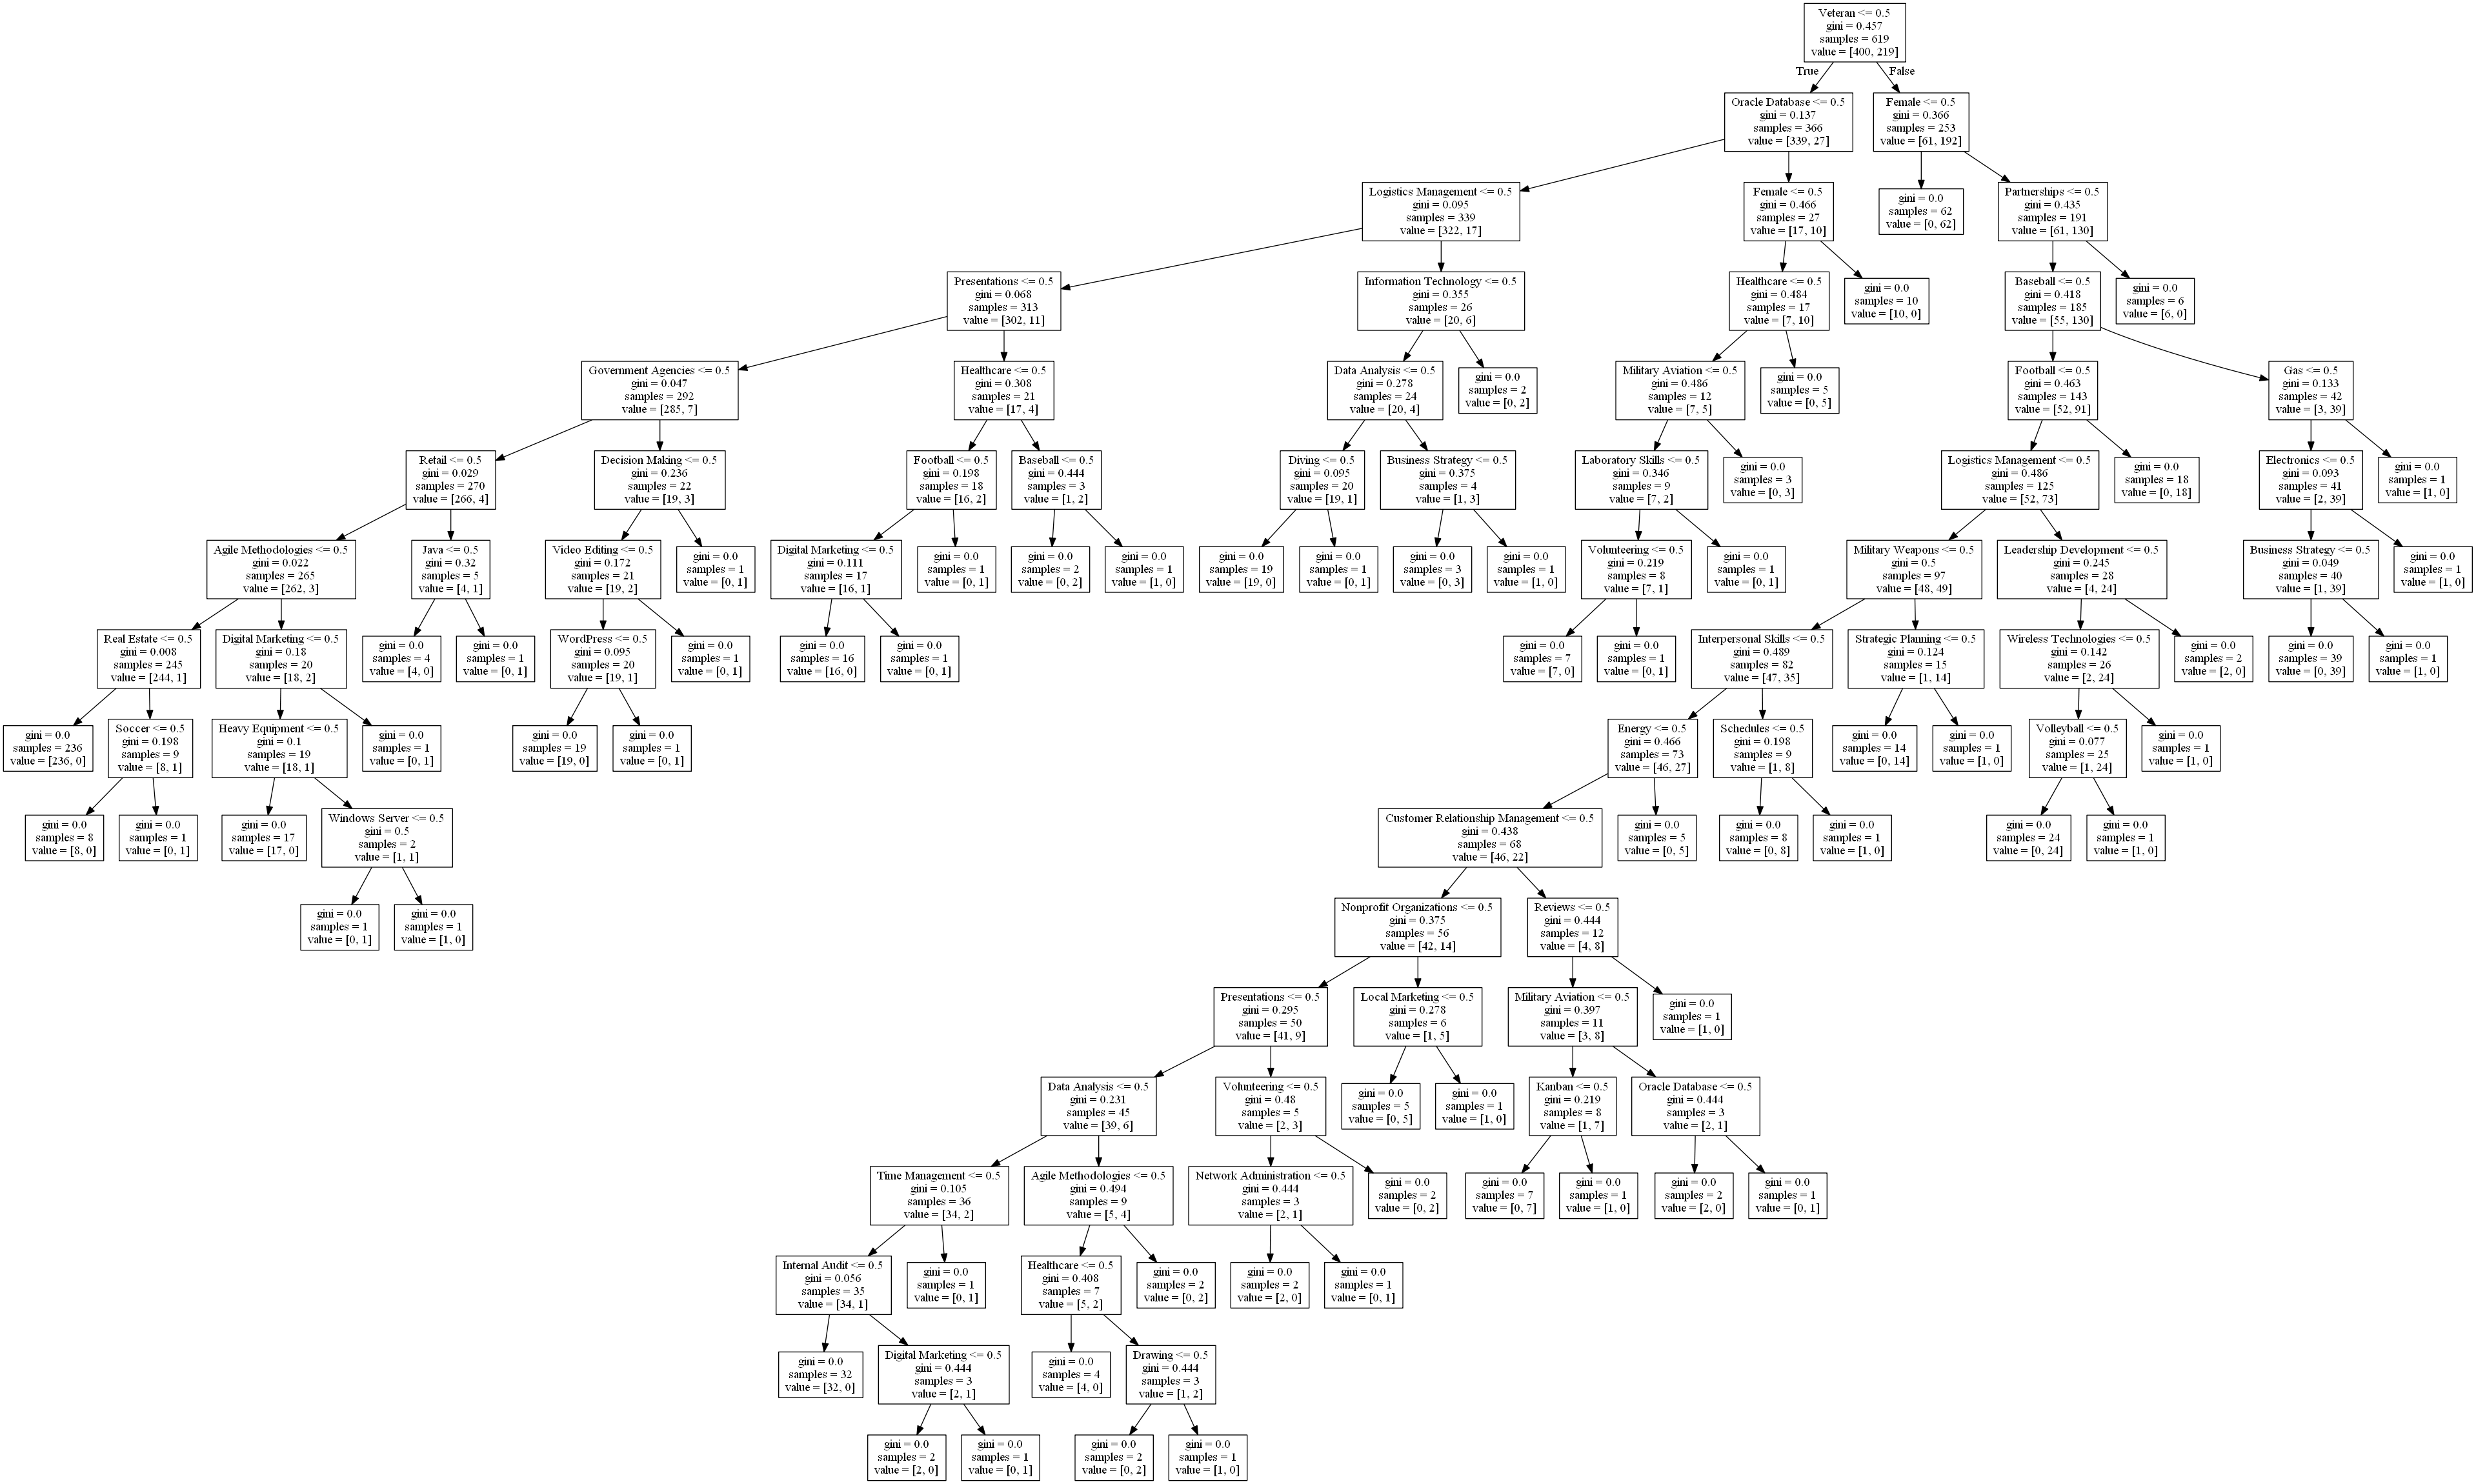

In [17]:
visualizeTree(df)

As you can see, we get a flow chart of the decisions taken by the algorithm. Just a simple rule ,for illustration sake, we can conclude that if you are a veteran and a male then you are very likely to get a job interview, if you are a female tho there is other factors to be considered (this is considered bad, since we a rule like this in its large sense sounds biased,but after some invistigations we found that almost 60% of the invited for interviews candidates are female, so this rule is not enough to judge the gender bias of the model).

We can also notice that the algorithm judged the **Disability** and also the **URM(Underrepresented Minority)** as not really significant (by the Gini information criterion standards) in the process of chosing the candidates for Job interview, which is ethically a good thing to have.

## Ensemble learning examle: Random Forest

We'll use a random forest of 10 decision trees to see if that helps improve the accuracy, we'll be using 5-fold cross validation as before to ensure same conditions for comparison with standard decision tree algorithm.

In [46]:
def trainingRF(data,K,N):
    accuracy=0
    confMatrices=[]
    for k in range (K):
        train,test=crossValidation(folds,k)
        y=train[target]
        X=train[features]
        clf = RandomForestClassifier(n_estimators=N)
        clf = clf.fit(X, y)
        predictions=clf.predict(test[features])
        s=100*(predictions==test[target]).tolist().count(True)/len(predictions)
        accuracy=accuracy+s
        confMatrices.append(confusion_matrix(test[target], predictions))
    return(confMatrices,accuracy/K)

In [47]:
c,ac=trainingRF(df,5,10)
print(ac)

89.98015491965944


There is a clear improvement of the accuracy when using random forest algorithm, compared to plain decision tree algotithm, but as you know there is no free lunch in statistics and this cannot be true all the time on any dataset. 